In [1]:
# Importing packages
import numpy as np

# This is used to calculate the excution time of several loops
import time

# The interp1d function is the equivalent of interp1 in Matlab
from scipy.interpolate import interp1d

# This is used for the root_scalar function
import scipy.optimize as opt

import matplotlib.pyplot as plt
# The magic command below causes the resulting plots to be stored in the notebook document
# Only works in IPython Notebooks and not in regular Python files
%matplotlib inline

# needed for compact printing of numpy arrays
# use precision to set the number of decimal digits to display
# use suppress=True to show values in full decimals instead of using scientific notation
np.set_printoptions(suppress=True,precision=4,linewidth=np.inf)

#### The functions lgwt and acm are copied below.

In [2]:
def lgwt(N,a,b):
    """ Syntax: [x,w]=lgwt(N,a,b)
    
    This script is for computing definite integrals using Legendre-Gauss 
    Quadrature. Computes the Legendre-Gauss nodes and weights on an interval
    [a,b] with truncation order N.
    
    Suppose you have a continuous function f(x) which is defined on [a,b]
    which you can evaluate at any x in [a,b]. Simply evaluate it at all of
    the values contained in the x vector to obtain a vector f. Then compute
    the definite integral using sum(f.*w);
    
    Translated from Greg von Winckel's Matlab Script written on 02/25/2004
    """

    N = N-1
    N1 = N+1; N2 = N+2;

    xu = np.linspace(-1,1,N1)

    # Initial guess
    y=np.cos((2*np.arange(0,N+1)+1)*np.pi/(2*N+2))+(0.27/N1)*np.sin(np.pi*xu*N/N2)

    # Compute the zeros of the N+1 Legendre Polynomial
    # using the recursion relation and the Newton-Raphson method

    y0=2

    # Iterate until new points are uniformly within epsilon of old points
    while np.abs(y-y0).max() > np.finfo(float).eps:
        
        # Legendre-Gauss Vandermonde Matrix
        L=np.zeros((N1,N2))

        # Derivative of LGVM
        Lp=np.zeros((N1,N2))
        
        L[:,0]=1
        Lp[:,0]=0

        L[:,1]=y
        Lp[:,1]=1
        
         
        for k in np.arange(1,N1):
            L[:,k+1]=( (2*(k+1)-1)*y*L[:,k]-((k+1)-1)*L[:,k-1] )/(k+1)

            
        Lp=(N2)*(L[:,N1-1]-y*L[:,N2-1] )/(1-y**2)

        y0=y.copy()
        y=y0-L[:,N2-1]/Lp


    # Linear map from[-1,1] to [a,b]
    x = ((a*(1-y)+b*(1+y))/2).T

    # Compute the weights
    w = ((b-a)/((1-y**2)*Lp**2)*(N2/N1)**2).T
       
    return x, w

In [3]:
# scipy.stats.norm: a normal continuous random variable.
from scipy.stats import norm

# needed for Gauss-Lobatto only
from scipy.integrate import quad

# Adda-Cooper's method of approximating an AR(1) process with normally distributed innovation.
def acm(mu,rho,sigma,n,me=1):
    """ Syntax: [ss,tm,sd,sm,ssd,sac] = acm(mu,rho,sigma,n,me) 

    ss is state space, tm is transition matrix, sd is stationary distribution,
    sm is stationary mean, ssd is stationary standard deviation and sac is 
    stationary autocorrelation. mu is the mean of the AR process, rho is 
    the autocorrelation and sigma is the standard deviation of the innovation.
    n is the number of states and me stands for the method used in numerical integration.
    """
    
    tm = np.zeros((n,n))
    sg = sigma / (np.sqrt(1 - rho**2))     # sg is the variance of AR process
    
    # n + 1 interval nodes for defining the states, trucated at two ends.
    node = sg * norm.ppf(np.arange(0,n+1) / n + np.concatenate((np.array([np.spacing(1)]), np.zeros((1,7 - 1))[0],\
                                                                    (np.array([-np.spacing(1)]))))) + mu
    

    # lengths of n intervals.
    itv = node[1:n + 1] - node[0:n]
    

    ss = n * sg * (norm.pdf((node[0:n] - mu) / sg) - norm.pdf((node[1:n+1] - mu) / sg)) + mu
    
    # itvu is the upper bound of an interval, itvl likewise.
    f = lambda u,itvu,itvl: np.exp(-(u - mu)**2 / 2 / sg**2)*\
    (norm.cdf((itvu - mu*(1 - rho) - rho*u)/sigma) -\
     norm.cdf((itvl - mu*(1 - rho) - rho*u)/sigma)) / np.sqrt(2 * np.pi) / sg
    
    
    match me:
        case 1:
            # use Gauss-Legendre method

            # Generate 10 nodes and corresponding weights using Winckel's function lgwt.
            m = 10
            x,w = lgwt(m,-1,1)    

            start = time.perf_counter()
            for i in np.arange(0,n):
                f_i = lambda u: f(u,node[i + 1],node[i])
                tm[i,:] = 0.5 * itv * (np.matmul(w,f_i(np.matmul((x + 1)[:,np.newaxis], itv[np.newaxis,:]) / 2 \
                                                    + np.ones((m,1)) * node[0:n])))

                tm[i,:] = tm[i,:]/np.sum(tm[i,:])
                

            stop = time.perf_counter()
            print("Time of the Gauss-Legendre method is:", round(stop - start,4))

        
        case 2:
            # use recursive adaptive Gauss-Lobatto quadrature
            start = time.perf_counter()
            for i in np.arange(0,n):
                f_i = lambda u: f(u,node[i + 1],node[i])
                for j in np.arange(0,n):
                    tm[i,j] = quad(f_i,node[j],node[j + 1])[0]

                tm[i,:] = tm[i,:]/np.sum(tm[i,:])

            stop = time.perf_counter()
            print("Time of Gauss-Lobatto method is:", round(stop - start,4))

    sd = np.dot((np.concatenate((np.zeros((1,n - 1))[0],(np.array([1]))))),\
    np.linalg.inv((np.append(tm[:,0:n - 1] - np.eye(n,n - 1),np.ones((n,1)),1))))
    sd = sd / sum(sd)
    sm = np.dot(sd, ss)
    ssd = np.sqrt(np.dot((ss - sm)**2, sd.T))

    sac = (np.matmul((ss[:,np.newaxis] - sm),ss[np.newaxis,:] - sm) *\
           np.matmul(np.diag(sd),tm)).sum(axis=1).sum(axis=0) / ssd**2
        
        
    return ss,tm,sd,sm,ssd,sac

#### The Hodrick-Prescott filter function is copied below

In [4]:
def hp1(y,w):

    """ Syntax: yhp, ytr = hp1(y, w)
    
    This function computes the filtered series of y, using
    a smoothing parameter w. 
    
    The code is from I. Izvorski.
    """

    t, s = y.shape
    
    if t < s:
        y = y.T

    a = 6*w + 1
    b = -4*w
    c = w
    d = np.array([[c,b,a]])
    d = np.ones((t,1))*d
    m = np.diag(d[:,2])+np.diag(d[0:-1,1],1)+np.diag(d[0:-1,1],-1)
    m = m+np.diag(d[0:-2,0],2)+np.diag(d[0:-2,0],-2)

    m[0,0] = 1+w;       m[0,1] = -2*w;
    m[1,0] = -2*w;      m[1,1] = 5*w+1;
    m[-2,-2] = 5*w+1;   m[-2,-1] = -2*w;
    m[-1,-2] = -2*w;    m[-1,-1] = 1+w;
    
    ytr = np.matmul(np.linalg.inv(m),y)
    
    yhp = y-ytr

    return yhp, ytr

In [5]:
# Simulate discrete finite state Markov chain
# Yan Liu, 2011.4.7

def mcsim(ss,tm,T):
    # ss is state space, tm is transition matrix, and
    # T is the number of periods to be simulated

    n = ss.size
    sd = np.matmul((np.concatenate((np.zeros((1,n - 1))[0],(np.array([1]))))),\
    np.linalg.inv((np.append(tm[0:n - 1,:].T - np.eye(n,n - 1),np.ones((n,1)),1)))) # stationary distribution
    
    sd = sd.T / np.sum(sd)
    
    Ix = np.zeros((T,1),dtype=int)    # indices of the chain
    y = np.random.random((T,1))      # random vector

    Ix[0] = np.argwhere(sd.cumsum() >= y[0])[0]

    tmcum = np.cumsum(tm,1).T    # use the transpose to accelerate computations
    for t in np.arange(1,T):
        Ix[t] = np.argwhere(tmcum[:,Ix[t - 1]] >= y[t])[0,0]

    return Ix

In [6]:
# Declarations
beta = 0.99
sigma = 1
delta = 0.025
theta = 0.36
a = 2
Ez = 1   # expectation of shock
lam = 0.9

In [7]:
plots = 1
simu = 1
loadin = 0

In [8]:
# Shock
zz,pi = acm(0,0.95,0.00712,7,1)[0:2]
zz = np.exp(zz) #acm returns the log productivity shock

Time of the Gauss-Legendre method is: 0.002


In [9]:
# Grid dimensions
ns = zz.size
N = 301
T = ns*N

In [10]:
# Grid on capital
k = np.zeros((N,1))
k[0] = 1
k[N-1] = 120
for i in np.arange(1,N-1):
    k[i]=k[0]+i*(k[N-1]-k[0])/(N-1)


In [11]:
# Define Steady state variables
xx = (1-beta*(1-delta))/(beta*theta*Ez)
yy = ((1/beta+delta-1)/theta*(1+(1-theta)/a)-delta)*a/((1-theta)*Ez)
l_ss = xx/yy  # for this set of parameters, the steady state labor approxiamately equals to 1/3
k_ss = xx**(1/(theta-1))*l_ss
y_ss = Ez*k_ss**theta*l_ss**(1-theta)
i_ss = delta*k_ss
c_ss = y_ss-i_ss

In [12]:
# Initialization of policies
r = np.zeros((N,ns))
w = np.zeros((N,ns))
c = np.zeros((N,ns))
h = np.zeros((N,ns))
kpr = np.zeros((N,ns))

if loadin==0:
    # Initial Policy Functions
    for m in np.arange(0,ns):
        for i in np.arange(0,N):
            h[i,m]=0.3
            r[i,m]=theta*zz[m]*h[i,m]**(1-theta)*k[i]**(theta-1)+1-delta
            w[i,m]=(1-theta)*zz[m]*h[i,m]**(-theta)*k[i]**(theta)
            c[i,m]=max(0.001,(zz[m]*h[i,m]**(1-theta)*k[i]**(theta)-delta*k[i]))
            kpr[i,m]=max(k[0],w[i,m]*h[i,m]+r[i,m]*k[i]-c[i,m])
            kpr[i,m]=min(kpr[i,m],k[N-1])

else:
    with open('polrbc.npy', 'rb') as f:
        polrbc = np.load(f)
    A = polrbc.copy()
    
    for i in np.arange(0,ns):
        for l in np.arange(0,N):
            c[l,i]=A[l+i*N,1]
            kpr[l,i]=A[l+i*N,2]
            h[l,i]=A[l+i*N,3]
            r[l,i]=A[l+i*N,4]
            w[l,i]=A[l+i*N,5]



cpp = np.zeros((ns,ns))
hp = np.zeros((ns,ns))

cn = np.zeros((N,ns))
hn = np.zeros((N,ns))
kprn = np.zeros((N,ns))

niter = 0
err = np.array([10.,10.,10.])
interma = 0

if loadin==0:
    tol = 0.0001
else:
    tol = 0.001

while np.amax(err)>tol:
    #if niter>1000:
    #    break
    
    niter=niter+1
    for m in np.arange(0,ns):
        for i in np.arange(0,N):
            if interma==1:
                cpp=(interp1d(k.squeeze(),c,axis=0)(kpr[i,m]))**(-sigma)
                hp=interp1d(k.squeeze(),h,axis=0)(kpr[i,m])
            else:
                mm = np.abs(kpr[i,m]-k).argmin()
                
                if (kpr[i,m]<=k[mm] and mm>0):
                    weight=(k[mm]-kpr[i,m])/(k[mm]-k[mm-1])
                    cpp=((weight*c[mm-1,:]+(1-weight)*c[mm,:])**(-sigma)).T
                    hp=(weight*h[mm-1,:]+(1-weight)*h[mm,:]).T;
                else:
                    weight=(k[mm+1]-kpr[i,m])/(k[mm+1]-k[mm])
                    cpp=((weight*c[mm,:]+(1-weight)*c[mm+1,:])**(-sigma)).T
                    hp=(weight*h[mm,:]+(1-weight)*h[mm+1,:]).T
                    

            cn[i,m]=max(0.001,(beta*np.sum(cpp*(theta*zz.squeeze()*hp.squeeze()**(1-theta)*kpr[i,m]**(theta-1)+\
                                                1-delta)*(pi[m,:].T)))**(-1/sigma))

            func = lambda x: a*cn[i,m]-(1-theta)*zz[m]*(k[i]**theta)*(x**(-theta))*(1-x)
            hn[i,m] = opt.root_scalar(func, bracket=[0.00001,1-0.00001]).root
            if hn[i,m] < 0:
                hn[i,m] = 0
            
            if hn[i,m] > 1:
                hn[i,m] = 1
            
            
            r[i,m]=theta*zz[m]*hn[i,m]**(1-theta)*k[i]**(theta-1)+1-delta
            w[i,m]=(1-theta)*zz[m]*hn[i,m]**(-theta)*k[i]**theta
            kprn[i,m]=max(k[0],w[i,m]*hn[i,m]+r[i,m]*k[i]-cn[i,m])
            kprn[i,m]=min(kprn[i,m],k[N-1])

    err[0]=np.abs((c-cn)).max()
    err[1]=np.abs((kpr-kprn)).max()
    err[2]=np.abs((h-hn)).max()

    print("iteration =", niter, ", Error =", err[0], err[1], err[2])
    c=lam*c+(1-lam)*cn
    kpr=lam*kpr+(1-lam)*kprn
    h=lam*h+(1-lam)*hn


polrbc=np.zeros((N*ns,6))
for m in np.arange(0,ns):
    for i in np.arange(0,N):
        polrbc[i+m*N,0]=k[i]
        polrbc[i+m*N,1]=c[i,m]
        polrbc[i+m*N,2]=kpr[i,m]
        polrbc[i+m*N,3]=h[i,m]
        polrbc[i+m*N,4]=r[i,m]
        polrbc[i+m*N,5]=w[i,m]


with open('polrbc.npy', 'wb') as f:
    np.save(f, polrbc)


iteration = 1 , Error = 0.055865723129232214 3.0890937297649117 0.6994474061113054
iteration = 2 , Error = 0.05441343191724329 2.780179551523844 0.6295017940062557
iteration = 3 , Error = 0.052981201445597925 2.50215655825464 0.5667056259884985
iteration = 4 , Error = 0.051568025184001276 2.251935706392132 0.510233992510711
iteration = 5 , Error = 0.050173246058878795 2.0267368272690334 0.4604668623848194
iteration = 6 , Error = 0.04879657384320857 1.8240577528528519 0.41491443520620785
iteration = 7 , Error = 0.04743805165836518 1.6416465224801442 0.37612833074812646
iteration = 8 , Error = 0.04609800826232735 1.4774763658197259 0.33887789578276073
iteration = 9 , Error = 0.045219886746837995 1.3297231855866158 0.3067828909410818
iteration = 10 , Error = 0.046165738694864664 1.1967452916009051 0.27786208696513404
iteration = 11 , Error = 0.046882101928536944 1.0770651607846986 0.2505611302273276
iteration = 12 , Error = 0.047553991955328855 0.969353020934804 0.22695510966824073
iterat

iteration = 98 , Error = 0.06138802769170343 0.17639311979782235 0.036642538565150096
iteration = 99 , Error = 0.06165178092555207 0.1770522577695175 0.03681033396864275
iteration = 100 , Error = 0.061903889093785774 0.1777463714600458 0.03697725228060866
iteration = 101 , Error = 0.062147259999955184 0.17840356651552725 0.03716256877062363
iteration = 102 , Error = 0.062426841459399696 0.17907698329653954 0.037339633125828664
iteration = 103 , Error = 0.06269374685840778 0.17981366943919852 0.037511699406989285
iteration = 104 , Error = 0.06294728951652376 0.18050997967026916 0.037706297199932126
iteration = 105 , Error = 0.06323859744730789 0.18120430651143948 0.03789171510525391
iteration = 106 , Error = 0.06352046383454396 0.18198253129956754 0.038070476237015316
iteration = 107 , Error = 0.06378782869995511 0.18271793999900154 0.038273979400620384
iteration = 108 , Error = 0.06409000671885542 0.18344061954164914 0.03846778588224242
iteration = 109 , Error = 0.06438610153459726 0.1

iteration = 194 , Error = 0.11901353937926878 0.32698261854547894 0.07341663287942612
iteration = 195 , Error = 0.1204606781704981 0.32989665246618216 0.07419435291390442
iteration = 196 , Error = 0.12161730608933702 0.333851343656697 0.07501717516643258
iteration = 197 , Error = 0.1232088127236669 0.33708901542130576 0.0758739951095655
iteration = 198 , Error = 0.12450644755157991 0.3409945770188827 0.07667206670681503
iteration = 199 , Error = 0.1260543149096695 0.34461896721804663 0.0776221367832266
iteration = 200 , Error = 0.1275328373741858 0.34840250794781014 0.07845263131183366
iteration = 201 , Error = 0.12880931487380637 0.3524894733268411 0.07943833344222684
iteration = 202 , Error = 0.13068124393078728 0.35601493180971033 0.08036690281014569
iteration = 203 , Error = 0.13200744144474474 0.3606914455886212 0.08131970423226365
iteration = 204 , Error = 0.13372629213503634 0.36432442506666973 0.08235416165211673
iteration = 205 , Error = 0.1354955915343063 0.36913349512835225 

iteration = 292 , Error = 0.6278393332012077 1.6268331084417227 0.3745745420614638
iteration = 293 , Error = 0.6194427529871261 1.6215028388561947 0.380972731990352
iteration = 294 , Error = 0.6581805806065094 1.6958618151893603 0.3804053540585175
iteration = 295 , Error = 0.6540271999952203 1.7036302832346735 0.3893712197386302
iteration = 296 , Error = 0.6426085416825412 1.6906625906239725 0.39417366411615395
iteration = 297 , Error = 0.6054176587381916 1.6012549519875279 0.37729469049349873
iteration = 298 , Error = 0.6099809597870012 1.5444334180504953 0.3535938066120442
iteration = 299 , Error = 0.6845203082213539 1.775897781806563 0.4088885410961275
iteration = 300 , Error = 0.6652541984925663 1.74153507769676 0.4082570973661306
iteration = 301 , Error = 0.6411980331838498 1.6923701843839822 0.4032954057282623
iteration = 302 , Error = 0.5913050356652216 1.5652723676219296 0.37520995179469807
iteration = 303 , Error = 0.5439692077863503 1.4437817905342882 0.34792764278713073
iter

iteration = 389 , Error = 0.01638576704153638 0.03239631296304424 0.004265059301670704
iteration = 390 , Error = 0.01616297926384802 0.0319375948360161 0.004199655590777729
iteration = 391 , Error = 0.015942917589395478 0.03148501335108733 0.004135270658368384
iteration = 392 , Error = 0.015725572933396048 0.031038528108691565 0.0040718925576270215
iteration = 393 , Error = 0.015510934693143685 0.030598096180764145 0.004009509163866665
iteration = 394 , Error = 0.01529899082587427 0.03016367226751626 0.003948108194886668
iteration = 395 , Error = 0.015089727975729161 0.029735208949226433 0.0038876772433267537
iteration = 396 , Error = 0.014883131554293882 0.02931265684575024 0.0038282037967869165
iteration = 397 , Error = 0.014679185819349128 0.028895964771667337 0.0037696752571196868
iteration = 398 , Error = 0.014477873956563636 0.02848507989614646 0.0037120789601146342
iteration = 399 , Error = 0.0142791780927094 0.028079947768102187 0.003655402177620254
iteration = 400 , Error = 0.

iteration = 481 , Error = 0.004651329716742314 0.008924078674588998 0.0011023723770872407
iteration = 482 , Error = 0.004590046843255591 0.008805075693395281 0.0010872928441476304
iteration = 483 , Error = 0.004529625637343271 0.008687782337553074 0.001072439638481637
iteration = 484 , Error = 0.004470053127060947 0.008572171912810234 0.0010578089721590689
iteration = 485 , Error = 0.004411316515904762 0.00845821811674341 0.0010433971208894666
iteration = 486 , Error = 0.004353403194672145 0.008345895059797215 0.0010292004261451548
iteration = 487 , Error = 0.004296300749120352 0.008235177278297812 0.0010152152963067984
iteration = 488 , Error = 0.004239996964355841 0.008126039741320312 0.0010014382070552275
iteration = 489 , Error = 0.004184479826694343 0.008018457852685401 0.000987865701183921
iteration = 490 , Error = 0.004129737523606902 0.007912407449346404 0.0009744943879781698
iteration = 491 , Error = 0.004075758442235289 0.007807864797090502 0.0009613209422754954
iteration = 4

iteration = 573 , Error = 0.001436372055708679 0.0027319025705843103 0.0003311514967420104
iteration = 574 , Error = 0.0014187930848066355 0.0026983344588913383 0.00032704718120299403
iteration = 575 , Error = 0.0014014416001539853 0.002665203919704595 0.0003229972042030349
iteration = 576 , Error = 0.0013843144658278739 0.0026325048441897536 0.000319000786887097
iteration = 577 , Error = 0.0013674085921131507 0.0026002312154282947 0.0003150571626218124
iteration = 578 , Error = 0.0013507209347927152 0.0025683771069786587 0.0003111655767871757
iteration = 579 , Error = 0.001334248494438528 0.002536936681401869 0.0003073252865705145
iteration = 580 , Error = 0.0013179883157212746 0.0025059041888262357 0.0003035355607663992
iteration = 581 , Error = 0.0013019374867266897 0.0024752739655724554 0.00029979567957802433
iteration = 582 , Error = 0.0012860931382798757 0.0024450404327396313 0.00029610493442258634
iteration = 583 , Error = 0.001270452443280723 0.0024151980949085328 0.00029246262

iteration = 662 , Error = 0.000495021067803858 0.0009389511075852397 0.00011314483340763015
iteration = 663 , Error = 0.0004892860896388296 0.0009280572493217676 0.00011182795080141861
iteration = 664 , Error = 0.0004836206086096251 0.0009172957603560405 0.00011052716311635291
iteration = 665 , Error = 0.0004780237378314567 0.0009066649433009388 0.00010924226182057462
iteration = 666 , Error = 0.00047249460246967523 0.0008961631240360646 0.00010797304128815077
iteration = 667 , Error = 0.00046703233956768564 0.0008857886513347069 0.00010671929875649688
iteration = 668 , Error = 0.00046163609786975535 0.0008755398965440975 0.00010548083428124633
iteration = 669 , Error = 0.00045630503765803354 0.0008654152532834303 0.00010425745069608805
iteration = 670 , Error = 0.0004510383305784682 0.0008554131370281937 0.00010304895356866295
iteration = 671 , Error = 0.000445835159480934 0.0008455319849289822 0.00010185515116073462
iteration = 672 , Error = 0.0004406947182502563 0.000835770255338985

iteration = 751 , Error = 0.00017948364658404437 0.0003401183189488677 5.53134720168158e-05
iteration = 752 , Error = 0.00017749172069425612 0.0003363415817148052 5.541538271913726e-05
iteration = 753 , Error = 0.00017552276701837677 0.0003326084452019984 5.551748139753787e-05
iteration = 754 , Error = 0.0001735765097834463 0.0003289183850192501 5.561976839729699e-05
iteration = 755 , Error = 0.00017165267668350914 0.0003252708833798579 5.5722244064360105e-05
iteration = 756 , Error = 0.00016975099883653755 0.000321665429041218 5.5824908745005786e-05
iteration = 757 , Error = 0.0001678712107358038 0.00031810151717337476 5.592776278651179e-05
iteration = 758 , Error = 0.00016601305020813584 0.0003145786493377045 5.603080653648895e-05
iteration = 759 , Error = 0.00016417625836595562 0.0003110963333448069 5.613404034332525e-05
iteration = 760 , Error = 0.0001623605795688654 0.00030765408317634524 5.623746455607481e-05
iteration = 761 , Error = 0.00016056576137546408 0.00030425141897083563

iteration = 840 , Error = 8.803732486164367e-05 0.00026392679301068256 6.516044724802494e-05
iteration = 841 , Error = 8.820009799940728e-05 0.00026441444211400267 6.528051500742649e-05
iteration = 842 , Error = 8.836317324530368e-05 0.0002649029950845261 6.540080410399884e-05
iteration = 843 , Error = 8.852655116240414e-05 0.0002653924536133445 6.552131494463875e-05
iteration = 844 , Error = 8.869023231484162e-05 0.00026588281936312796 6.564204793702011e-05
iteration = 845 , Error = 8.885421726782805e-05 0.00026637409402496814 6.576300348948294e-05
iteration = 846 , Error = 8.901850658764223e-05 0.0002668662792757459 6.58841820114775e-05
iteration = 847 , Error = 8.918310084164282e-05 0.0002673593768633964 6.600558391312017e-05
iteration = 848 , Error = 8.93480005982588e-05 0.0002678533884505896 6.612720960508245e-05
iteration = 849 , Error = 8.951320642700683e-05 0.00026834831571420636 6.624905949881299e-05
iteration = 850 , Error = 8.96787188984817e-05 0.00026884416037376013 6.63711

iteration = 930 , Error = 0.00010396582339749095 0.0003116409651511276 7.69028047993281e-05
iteration = 931 , Error = 0.00010415817234393689 0.0003122170799798596 7.704451506251875e-05
iteration = 932 , Error = 0.00010435087860683704 0.00031279426333696847 7.718648647248028e-05
iteration = 933 , Error = 0.00010454394285416314 0.00031337251719776305 7.73287195097172e-05
iteration = 934 , Error = 0.00010473736575515331 0.00031395184356597383 7.747121465540019e-05
iteration = 935 , Error = 0.00010493114798032065 0.0003145322444595422 7.761397239181012e-05
iteration = 936 , Error = 0.0001051252902014594 0.0003151137218679878 7.7756993201894e-05
iteration = 937 , Error = 0.00010531979309163272 0.00031569627779504117 7.790027756970908e-05
iteration = 938 , Error = 0.00010551465732518573 0.00031627991423022195 7.804382598008974e-05
iteration = 939 , Error = 0.00010570988357775854 0.00031686463324831493 7.818763891864755e-05
iteration = 940 , Error = 0.0001059054725262628 0.0003174504367962072

iteration = 1018 , Error = 0.00012233670088545017 0.00036665696725890484 9.042782628576607e-05
iteration = 1019 , Error = 0.00012256319605973356 0.00036733516536457955 9.0594457528681e-05
iteration = 1020 , Error = 0.00012279011247867504 0.00036801462248092776 9.07613957679132e-05
iteration = 1021 , Error = 0.00012301745093207424 0.00036869534096695133 9.092864156834413e-05
iteration = 1022 , Error = 0.0001232452122112513 0.00036937732315323046 9.109619549585446e-05
iteration = 1023 , Error = 0.0001234733971090321 0.0003700605713419236 9.126405811732408e-05
iteration = 1024 , Error = 0.00012370200641974825 0.0003707450880057195 9.143223000074308e-05
iteration = 1025 , Error = 0.00012393104093926053 0.0003714308754609874 9.16007117153228e-05
iteration = 1026 , Error = 0.00012416050146494932 0.000372117936095151 9.176950383071869e-05
iteration = 1027 , Error = 0.0001243903887957103 0.0003728062722956338 9.193860691847355e-05
iteration = 1028 , Error = 0.0001246207037319709 0.000373495886

iteration = 1105 , Error = 0.0001437048425112523 0.0004306296392684317 0.00010613547288906844
iteration = 1106 , Error = 0.00014397110732296704 0.00043142666065421054 0.00010633104037482966
iteration = 1107 , Error = 0.00014423786806274166 0.00043222516333685235 0.00010652696809421158
iteration = 1108 , Error = 0.00014450512566336303 0.0004330251500164195 0.00010672325671001737
iteration = 1109 , Error = 0.00014477288105939866 0.0004338266234782395 0.0001069199068862714
iteration = 1110 , Error = 0.00014504113518721586 0.0004346295865218508 0.00010711691928777523
iteration = 1111 , Error = 0.00014530988898498083 0.0004354340419467917 0.00010731429458110675
iteration = 1112 , Error = 0.00014557914339265524 0.0004362399925241789 0.00010751203343384308
iteration = 1113 , Error = 0.00014584889935201004 0.00043704744105355076 0.00010771013651467154
iteration = 1114 , Error = 0.00014611915780662205 0.00043785639040549995 0.00010790860449361173
iteration = 1115 , Error = 0.0001463899197018826

iteration = 1192 , Error = 0.00016882813880947194 0.0005058180110353305 0.00012457051452952062
iteration = 1193 , Error = 0.0001691412368776419 0.0005067548617034845 0.0001248000356048884
iteration = 1194 , Error = 0.00016945491911820286 0.0005076934558587709 0.00012502997936791882
iteration = 1195 , Error = 0.00016976918663385958 0.000508633796798108 0.00012526034659587904
iteration = 1196 , Error = 0.00017008404052942273 0.0005095758877899925 0.00012549113806781254
iteration = 1197 , Error = 0.0001703994819118506 0.0005105197320602883 0.00012572235456387304
iteration = 1198 , Error = 0.0001707155118902369 0.0005114653329627572 0.00012595399686599063
iteration = 1199 , Error = 0.0001710321315758212 0.0005124126937801066 0.0001261860657573166
iteration = 1200 , Error = 0.00017134934208198373 0.0005133618178376764 0.0001264185620223346
iteration = 1201 , Error = 0.00017166714452426096 0.0005143127084181742 0.00012665148644697144
iteration = 1202 , Error = 0.00017198554002034738 0.000515

iteration = 1279 , Error = 0.0001983748436159838 0.0005942078729077593 0.00014620578830126796
iteration = 1280 , Error = 0.00019874312550610673 0.0005953093486397165 0.000146475148304126
iteration = 1281 , Error = 0.00019911209594655407 0.0005964128775275412 0.0001467450042572649
iteration = 1282 , Error = 0.00019948175624236522 0.000597518463436586 0.0001470153570716226
iteration = 1283 , Error = 0.00019985210770115912 0.0005986261102748358 0.0001472862076593584
iteration = 1284 , Error = 0.0002002231516330666 0.0005997358218792215 0.00014755755693485195
iteration = 1285 , Error = 0.00020059488935078758 0.0006008476021719389 0.00014782940581370418
iteration = 1286 , Error = 0.00020096732216957035 0.0006019614550467622 0.00014810175521329239
iteration = 1287 , Error = 0.00020134045140722708 0.0006030773843974657 0.00014837460605321429
iteration = 1288 , Error = 0.00020171427838413906 0.0006041953941462452 0.00014864795925439989
iteration = 1289 , Error = 0.0002020888044232446 0.0006053

iteration = 1366 , Error = 0.00023313541543100273 0.000698144324658756 0.00017159589995840996
iteration = 1367 , Error = 0.00023356876460921792 0.0006994397211457226 0.00017191200162525178
iteration = 1368 , Error = 0.00023400292595528172 0.000700737536888596 0.00017222868513222522
iteration = 1369 , Error = 0.00023443790101587356 0.0007020377764206387 0.000172545951548142
iteration = 1370 , Error = 0.00023487369134073816 0.0007033404443319569 0.00017286380194381223
iteration = 1371 , Error = 0.0002353102984826317 0.0007046455452126565 0.00017318223739215544
iteration = 1372 , Error = 0.00023574772399737043 0.0007059530836812655 0.00017350125896775648
iteration = 1373 , Error = 0.00023618596944383584 0.0007072630643563116 0.0001738208677475317
iteration = 1374 , Error = 0.00023662503638395734 0.0007085754918279008 0.00017414106481006275
iteration = 1375 , Error = 0.00023706492638274346 0.0007098903707429827 0.0001744618512358187
iteration = 1376 , Error = 0.00023750564100826453 0.00071

iteration = 1454 , Error = 0.0002745561846311112 0.0008219235012063564 0.00020176211600420046
iteration = 1455 , Error = 0.0002750672737833592 0.0008234503206097088 0.00020213373397059975
iteration = 1456 , Error = 0.00027557932356144996 0.0008249799979012096 0.00020250603572458115
iteration = 1457 , Error = 0.0002760923358050265 0.0008265125384241401 0.00020287902252147383
iteration = 1458 , Error = 0.000276606312357406 0.0008280479477207336 0.00020325269561938253
iteration = 1459 , Error = 0.00027712125506553116 0.0008295862312053259 0.00020362705627829936
iteration = 1460 , Error = 0.00027763716578002584 0.0008311273943064634 0.00020400210576065891
iteration = 1461 , Error = 0.00027815404635518105 0.0008326714425379578 0.00020437784533144931
iteration = 1462 , Error = 0.0002786718986489724 0.0008342183813851989 0.00020475427625743503
iteration = 1463 , Error = 0.00027919072452305994 0.0008357682163193658 0.0002051313998082671
iteration = 1464 , Error = 0.0002797105258427954 0.000837

iteration = 1542 , Error = 0.00032342000245297667 0.0009678448591472488 0.00023722529639069734
iteration = 1543 , Error = 0.0003240230879742144 0.0009696451686238561 0.00023766215377540867
iteration = 1544 , Error = 0.0003246273108675722 0.0009714488567595936 0.00023809981462019625
iteration = 1545 , Error = 0.00032523267332535896 0.0009732559300488219 0.00023853828039854807
iteration = 1546 , Error = 0.0003258391775443001 0.0009750663949859018 0.00023897755258606157
iteration = 1547 , Error = 0.00032644682572551334 0.000976880258022561 0.00023941763266166483
iteration = 1548 , Error = 0.00032705562007453656 0.0009786975256247388 0.00023985852210639536
iteration = 1549 , Error = 0.0003276655628013554 0.000980518204329428 0.00024030022240462134
iteration = 1550 , Error = 0.00032827665612038953 0.000982342300574146 0.0002407427350428204
iteration = 1551 , Error = 0.00032888890225048206 0.0009841698210095728 0.00024118606151068978
iteration = 1552 , Error = 0.00032950230341495176 0.000986

iteration = 1630 , Error = 0.00038109660973407664 0.0011399868010784076 0.00027891254940914934
iteration = 1631 , Error = 0.0003818086820773746 0.0011421106798223946 0.00027942605786368535
iteration = 1632 , Error = 0.0003825221026560119 0.0011442385566056146 0.0002799405102373864
iteration = 1633 , Error = 0.0003832368740884218 0.0011463704390450857 0.0002804559082578706
iteration = 1634 , Error = 0.00038395299899837004 0.0011485063349567781 0.00028097225365641965
iteration = 1635 , Error = 0.00038467048001497237 0.0011506462519861316 0.00028148954816720195
iteration = 1636 , Error = 0.0003853893197726978 0.0011527901979491162 0.0002820077935276055
iteration = 1637 , Error = 0.0003861095209113652 0.0011549381805906478 0.00028252699147790494
iteration = 1638 , Error = 0.00038683108607617117 0.0011570902076414313 0.0002830471437618165
iteration = 1639 , Error = 0.00038755401791770727 0.0011592462869884912 0.0002835682521260541
iteration = 1640 , Error = 0.0003882783190919531 0.001161406

iteration = 1718 , Error = 0.00044922025754211975 0.0013430732417845093 0.0003279116987159325
iteration = 1719 , Error = 0.0004500616111604537 0.0013455801273636325 0.0003285152425380744
iteration = 1720 , Error = 0.0004509045651891197 0.0013480917494064215 0.00032911989502326655
iteration = 1721 , Error = 0.0004517491227636443 0.0013506081171499318 0.0003297256582017738
iteration = 1722 , Error = 0.0004525952870260662 0.001353129239731743 0.0003303325341069696
iteration = 1723 , Error = 0.0004534430611248773 0.0013556551263604888 0.00033094052477666835
iteration = 1724 , Error = 0.0004542924482151267 0.001358185786259014 0.000331549632251682
iteration = 1725 , Error = 0.00045514345145834453 0.0013607212286501635 0.0003321598585769303
iteration = 1726 , Error = 0.00045599607402262154 0.0013632614627567818 0.00033277120580055275
iteration = 1727 , Error = 0.0004568503190825954 0.0013658064979154005 0.0003333836759750186
iteration = 1728 , Error = 0.00045770618981946787 0.001368356343391

iteration = 1806 , Error = 0.0005297455320655391 0.001582860473874348 0.00038549883252858574
iteration = 1807 , Error = 0.000530740471314621 0.0015858213639887708 0.0003862081149282881
iteration = 1808 , Error = 0.0005317373134016076 0.0015887878721230209 0.0003869186989982065
iteration = 1809 , Error = 0.000532736062092587 0.0015917600092052453 0.0003876305871118868
iteration = 1810 , Error = 0.0005337367211615644 0.0015947377862630674 0.00038834378164676053
iteration = 1811 , Error = 0.0005347392943904281 0.0015977212142814778 0.0003890582849852553
iteration = 1812 , Error = 0.0005357437855691219 0.0016007103042170456 0.0003897740995139065
iteration = 1813 , Error = 0.0005367501984955142 0.0016037050671826591 0.0003904912276236905
iteration = 1814 , Error = 0.000537758536975453 0.0016067055142485742 0.0003912096717099134
iteration = 1815 , Error = 0.0005387688048228353 0.0016097116564282032 0.0003919294341723223
iteration = 1816 , Error = 0.000539781005859559 0.0016127235049196997 0.

iteration = 1894 , Error = 0.0006250167425378012 0.0018661807180535561 0.00045316911788328973
iteration = 1895 , Error = 0.0006261944621505158 0.0018696804995244065 0.0004540025154849969
iteration = 1896 , Error = 0.000627374448474001 0.0018731869543699986 0.00045483744068819387
iteration = 1897 , Error = 0.0006285567060474173 0.0018767000956785296 0.0004556738962687712
iteration = 1898 , Error = 0.0006297412394196816 0.0018802199366660943 0.0004565118850069494
iteration = 1899 , Error = 0.0006309280531494321 0.0018837464904919443 0.000457351409688167
iteration = 1900 , Error = 0.0006321171518051463 0.001887279770414807 0.00045819247310252553
iteration = 1901 , Error = 0.0006333085399650717 0.0018908197896081447 0.0004590350780449004
iteration = 1902 , Error = 0.0006345022222173022 0.0018943665613875282 0.00045987922731505204
iteration = 1903 , Error = 0.0006356982031598193 0.0018979200989690526 0.0004607249237177369
iteration = 1904 , Error = 0.0006368964874004374 0.001901480415739342

iteration = 1983 , Error = 0.000739250500051282 0.002205354585811392 0.000533650931642593
iteration = 1984 , Error = 0.0007406488980431503 0.0022095029722066784 0.0005346317266035072
iteration = 1985 , Error = 0.0007420500076822309 0.0022136593149042483 0.0005356143163814941
iteration = 1986 , Error = 0.0007434538344734606 0.002217823629749205 0.0005365987042320608
iteration = 1987 , Error = 0.0007448603839339055 0.0022219959325440186 0.0005375848934162653
iteration = 1988 , Error = 0.0007462696615927189 0.002226176239190636 0.0005385728872007167
iteration = 1989 , Error = 0.0007476816729911698 0.002230364565619425 0.0005395626888581306
iteration = 1990 , Error = 0.0007490964236827533 0.0022345609278033862 0.0005405543016665515
iteration = 1991 , Error = 0.0007505139192331561 0.00223876534170131 0.0005415477289095749
iteration = 1992 , Error = 0.0007519341652202985 0.0022429778233572506 0.0005425429738767917
iteration = 1993 , Error = 0.0007533571672343198 0.0022471983888436853 0.00054

iteration = 2072 , Error = 0.0008749826946178388 0.0026075998263337397 0.0006283537688865914
iteration = 2073 , Error = 0.0008766454356374243 0.002612522287549268 0.0006295077005589178
iteration = 2074 , Error = 0.0008783114291798927 0.0026174542538655032 0.0006306637394407621
iteration = 2075 , Error = 0.000879980681952941 0.0026223957444102552 0.0006318218893174299
iteration = 2076 , Error = 0.0008816532006794622 0.002627346778382389 0.0006329821539807767
iteration = 2077 , Error = 0.0008833289920974693 0.00263230737499498 0.0006341445372297638
iteration = 2078 , Error = 0.0008850080629601922 0.0026372775534895254 0.0006353090428695696
iteration = 2079 , Error = 0.000886690420036064 0.0026422573331501553 0.0006364756747124778
iteration = 2080 , Error = 0.0008883760701087345 0.002647246733403108 0.0006376444365768785
iteration = 2081 , Error = 0.0008900650199772583 0.002652245773575146 0.0006388153322883783
iteration = 2082 , Error = 0.0008917572764559345 0.0026572544730782965 0.00063

iteration = 2161 , Error = 0.0010365038458321485 0.003085199281684936 0.0007397517185232516
iteration = 2162 , Error = 0.0010384841440026146 0.003091047584788953 0.0007411087773014913
iteration = 2163 , Error = 0.0010404683555326893 0.0030969072700912648 0.0007424683067942528
iteration = 2164 , Error = 0.001042456488639959 0.0031027783607981974 0.000743830311416116
iteration = 2165 , Error = 0.0010444485515612098 0.003108660880144498 0.0007451947955890992
iteration = 2166 , Error = 0.0010464445525521365 0.003114554851535445 0.0007465617637433253
iteration = 2167 , Error = 0.0010484444998877518 0.003120460298319472 0.0007479312203167998
iteration = 2168 , Error = 0.001050448401862164 0.0031263772440297544 0.0007493031697550778
iteration = 2169 , Error = 0.001052456266788758 0.003132305712085781 0.00075067761651193
iteration = 2170 , Error = 0.0010544681030001807 0.003138245726049149 0.0007520545650482324
iteration = 2171 , Error = 0.001056483918848515 0.0031441973095240883 0.00075343401

iteration = 2252 , Error = 0.0012337878644270023 0.003666971504031835 0.0008739181792192241
iteration = 2253 , Error = 0.0012361603858442177 0.0036739573474733334 0.0008755190679017311
iteration = 2254 , Error = 0.00123853765299628 0.0036809569147777665 0.000877122859920032
iteration = 2255 , Error = 0.0012409196760614916 0.0036879702343242116 0.000878729560381375
iteration = 2256 , Error = 0.0012433064652423442 0.00369499733473333 0.0008803391744013345
iteration = 2257 , Error = 0.0012456980307658377 0.0037020382445689393 0.0008819517071033678
iteration = 2258 , Error = 0.0012480943828835217 0.0037090929925227556 0.0008835671636193698
iteration = 2259 , Error = 0.0012504955318713706 0.0037161616073575487 0.000885185549089007
iteration = 2260 , Error = 0.001252901488030131 0.0037232441178360887 0.0008868068686602726
iteration = 2261 , Error = 0.0012553122616851126 0.0037303405528774647 0.0008884311274890422
iteration = 2262 , Error = 0.0012577278631865224 0.003737450941414977 0.0008900

iteration = 2342 , Error = 0.0014675825408793503 0.004354180025629262 0.001030247098578685
iteration = 2343 , Error = 0.0014704259861084146 0.004362523117876549 0.0010321307207058483
iteration = 2344 , Error = 0.0014732751991782395 0.004370882776825624 0.0010340177398135975
iteration = 2345 , Error = 0.0014761301927569276 0.0043792590374209794 0.001035908161799659
iteration = 2346 , Error = 0.0014789909795441536 0.004387651934877113 0.0010378019925707527
iteration = 2347 , Error = 0.0014818575722708727 0.004396061504252202 0.0010396992380429237
iteration = 2348 , Error = 0.0014847299836998062 0.004404487780917066 0.0010415999041405444
iteration = 2349 , Error = 0.0014876082266251783 0.004412930800157255 0.0010435039967976456
iteration = 2350 , Error = 0.0014904923138730763 0.0044213905974430645 0.0010454115219564741
iteration = 2351 , Error = 0.0014933822583014927 0.0044298672082447865 0.0010473224855684915
iteration = 2352 , Error = 0.0014962780728002278 0.004438360668189034 0.0010492

iteration = 2432 , Error = 0.0017481654848680167 0.005175740456422773 0.0012140641210034442
iteration = 2433 , Error = 0.0017515827064169542 0.005185724974467121 0.0012162773274324579
iteration = 2434 , Error = 0.00175500697318276 0.0051957295650026936 0.0012184944988378188
iteration = 2435 , Error = 0.0017584383010618293 0.005205754271344176 0.001220715647037962
iteration = 2436 , Error = 0.001761876705991386 0.005215799136919941 0.001222940782796944
iteration = 2437 , Error = 0.001765322203949829 0.005225864205243624 0.0012251699159863128
iteration = 2438 , Error = 0.001768774810956733 0.005235949519970973 0.001227403055724885
iteration = 2439 , Error = 0.0017722345430729175 0.005246055124814575 0.0012296402105002047
iteration = 2440 , Error = 0.0017757014164007101 0.005256181063586496 0.001231881388272571
iteration = 2441 , Error = 0.0017791754470839055 0.00526632738025512 0.0012341265965652992
iteration = 2442 , Error = 0.0017826566513080983 0.005276494118845676 0.00123637584254154

iteration = 2522 , Error = 0.0020859093394570843 0.006160104775091213 0.00142994817660691
iteration = 2523 , Error = 0.0020900294407523307 0.006172082275995194 0.0014325458230963761
iteration = 2524 , Error = 0.002094158197601559 0.006184084200000939 0.0014351480618288726
iteration = 2525 , Error = 0.0020982956301363875 0.006196110601052851 0.001437754901449817
iteration = 2526 , Error = 0.0021024417585425725 0.006208161533209022 0.001440366350579425
iteration = 2527 , Error = 0.002106596603059799 0.006220237050655442 0.00144298241776597
iteration = 2528 , Error = 0.002110760183982402 0.006232337207691785 0.0014456031114590262
iteration = 2529 , Error = 0.0021149325216591602 0.00624446205881668 0.001448228439994259
iteration = 2530 , Error = 0.002119113636493572 0.00625661165861402 0.0014508584115439094
iteration = 2531 , Error = 0.0021233035489440777 0.006268786061809806 0.0014534930340592833
iteration = 2532 , Error = 0.0021275022795240184 0.0062809853233147805 0.0014561323152537664


iteration = 2614 , Error = 0.0025038787864218592 0.007371434863699733 0.0016891129229228419
iteration = 2615 , Error = 0.0025088867653637603 0.007385902923601861 0.0016921651738061039
iteration = 2616 , Error = 0.002513905501501712 0.00740040097822714 0.0016952227392296182
iteration = 2617 , Error = 0.002518935020740576 0.0074149290955602964 0.0016982856274698754
iteration = 2618 , Error = 0.0025239753490580163 0.007429487343685537 0.0017013538472095968
iteration = 2619 , Error = 0.0025290265125046674 0.00744407579092865 0.001704427406805209
iteration = 2620 , Error = 0.002534088537204382 0.0074586945058001675 0.0017075063141596125
iteration = 2621 , Error = 0.002539161449354538 0.007473343556981149 0.001710590576877502
iteration = 2622 , Error = 0.002544245275226148 0.007488023013280554 0.0017136801997769124
iteration = 2623 , Error = 0.0025493400411643052 0.007502732943763135 0.0017167751887603444
iteration = 2624 , Error = 0.002554445773588321 0.00751747341753628 0.00171987555134311

iteration = 2706 , Error = 0.0030131114796562997 0.008837102350085502 0.0019931637113815848
iteration = 2707 , Error = 0.0030192274190599944 0.008854637808966004 0.0019967387367252343
iteration = 2708 , Error = 0.003025356836621612 0.008872210313271012 0.0020003198388980348
iteration = 2709 , Error = 0.00303149976608022 0.008889819949402522 0.002003907026366214
iteration = 2710 , Error = 0.0030376562412744446 0.00890746680389043 0.002007500307617316
iteration = 2711 , Error = 0.003043826296142582 0.008925150963534634 0.002011099691161422
iteration = 2712 , Error = 0.0030500099647233214 0.008942872515433464 0.002014705185529153
iteration = 2713 , Error = 0.0030562072811556873 0.008960631546827358 0.002018316799271891
iteration = 2714 , Error = 0.003062418279679513 0.008978428145198336 0.002021934540954673
iteration = 2715 , Error = 0.0030686429946359672 0.008996262398284216 0.0020255584191452014
iteration = 2716 , Error = 0.0030748814604678043 0.009014134394107032 0.0020291884424065154


iteration = 2797 , Error = 0.0036292367665408942 0.01059630056212768 0.0023443759685333188
iteration = 2798 , Error = 0.003636730460028492 0.010617593836286687 0.002348537483942592
iteration = 2799 , Error = 0.0036442411554492293 0.0106389329081793 0.002352705815172218
iteration = 2800 , Error = 0.0036517688972034223 0.010660317902150496 0.0023568809702475546
iteration = 2801 , Error = 0.003659313729829 0.010681748941379965 0.0023610629571824138
iteration = 2802 , Error = 0.0036668756980021977 0.010703226148152112 0.0023652517839768405
iteration = 2803 , Error = 0.0036744548465378057 0.01072474964388448 0.002369447458616891
iteration = 2804 , Error = 0.003682051220389726 0.01074631954934091 0.002373649989074078
iteration = 2805 , Error = 0.0036896648646518038 0.010767935984603128 0.0023778593833047035
iteration = 2806 , Error = 0.0036972958245580223 0.01078959906921284 0.0023820756492506368
iteration = 2807 , Error = 0.0037049441454827803 0.01081130892238491 0.00238629879483776
iterati

iteration = 2889 , Error = 0.004395813573095125 0.012762210415516506 0.0027567290182909376
iteration = 2890 , Error = 0.00440507611676888 0.012788231141598772 0.002761549045076972
iteration = 2891 , Error = 0.004414360393437539 0.012814309348129882 0.0027663765474984503
iteration = 2892 , Error = 0.004423666462581605 0.012840445177587867 0.002771211533676654
iteration = 2893 , Error = 0.004432994383875871 0.012866638772877081 0.0027760540084870167
iteration = 2894 , Error = 0.004442344217190669 0.012892890277285574 0.002780903977883331
iteration = 2895 , Error = 0.004451716022592228 0.012919199834541928 0.0027857614477855286
iteration = 2896 , Error = 0.004461109860343593 0.012945567588687368 0.0027906264240785683
iteration = 2897 , Error = 0.004470525790905289 0.012971993684274707 0.0027954989126131036
iteration = 2898 , Error = 0.004479963874936377 0.012998478266240454 0.0028003789192035944
iteration = 2899 , Error = 0.004489424173294926 0.013025021479919019 0.0028052664496291957
ite

iteration = 2980 , Error = 0.0053354849086375555 0.015383927032345923 0.0032264000050361563
iteration = 2981 , Error = 0.005346994537090921 0.015415814473016098 0.0032319122541994982
iteration = 2982 , Error = 0.005358532208976585 0.015447774175001427 0.003237432391317907
iteration = 2983 , Error = 0.005370098005010593 0.015479806323241974 0.0032429603773613813
iteration = 2984 , Error = 0.005381692006187266 0.015511911103047282 0.003248496189570016
iteration = 2985 , Error = 0.005393314293781426 0.015544088700423231 0.0032540398177127727
iteration = 2986 , Error = 0.005404964949348667 0.0155763393017736 0.003259591260980077
iteration = 2987 , Error = 0.005416644054726971 0.01560866309412745 0.003265150525407212
iteration = 2988 , Error = 0.005428351692037925 0.01564106026502543 0.003270717620849073
iteration = 2989 , Error = 0.005440087943687499 0.015673531002562413 0.0032762925552172195
iteration = 2990 , Error = 0.005451852892367326 0.015706075495401706 0.003281875331732076
iteratio

iteration = 3071 , Error = 0.006508306489656723 0.018605566274487728 0.003759855667386236
iteration = 3072 , Error = 0.006522735773841437 0.01864485634418145 0.0037660695525535415
iteration = 3073 , Error = 0.006537201741717402 0.018684237910548518 0.0037722908964440416
iteration = 3074 , Error = 0.006551704504738853 0.018723711214789773 0.003778519690858184
iteration = 3075 , Error = 0.006566244174767311 0.01876327649873133 0.003784755927455641
iteration = 3076 , Error = 0.006580820864073578 0.01880293400502353 0.0037909995977677413
iteration = 3077 , Error = 0.006595434685338797 0.01884268397695621 0.003797250693199805
iteration = 3078 , Error = 0.006610085751657058 0.018882526658472898 0.0038035092049519825
iteration = 3079 , Error = 0.006624774176536452 0.01892246229436978 0.0038097751240090405
iteration = 3080 , Error = 0.006639500073901183 0.01896249113012516 0.0038160484401192907
iteration = 3081 , Error = 0.0066542635580937315 0.01900261341187104 0.0038223291423937766
iteration

iteration = 3163 , Error = 0.00800458511174501 0.022637829460137482 0.004361250583841958
iteration = 3164 , Error = 0.00802291230626323 0.02268665060861963 0.0043680949396474045
iteration = 3165 , Error = 0.008041288387852286 0.022735588731706002 0.004374945264033037
iteration = 3166 , Error = 0.008059713513923816 0.02278464414645498 0.0043818015310187475
iteration = 3167 , Error = 0.008078187842499085 0.022833817170692328 0.004388663714369634
iteration = 3168 , Error = 0.00809671153221081 0.02288310812321015 0.004395531787593221
iteration = 3169 , Error = 0.008115284742306383 0.02293251732361057 0.004402405723939795
iteration = 3170 , Error = 0.008133907632650927 0.022982045092447834 0.004409285496400295
iteration = 3171 , Error = 0.008152580363729456 0.023031691751086214 0.004416171077705644
iteration = 3172 , Error = 0.008171303096649596 0.02308145762189895 0.004423062440325087
iteration = 3173 , Error = 0.00819007599314514 0.02313134302812614 0.004429959556464191
iteration = 3174 ,

iteration = 3255 , Error = 0.009916943151545343 0.027661510439060066 0.005021611314882768
iteration = 3256 , Error = 0.009940511756578452 0.027722542184548615 0.00502920769837345
iteration = 3257 , Error = 0.00996414666640777 0.027783724236570606 0.0050368225169289405
iteration = 3258 , Error = 0.009987848107893882 0.027845057007908736 0.0050444418579624895
iteration = 3259 , Error = 0.010011616308825966 0.02790654091249678 0.005052076589808663
iteration = 3260 , Error = 0.010035451497927006 0.027968176365462227 0.005059718901003762
iteration = 3261 , Error = 0.01005935390485757 0.028029963783083645 0.005067373636468919
iteration = 3262 , Error = 0.010083323760219476 0.0280919035828191 0.0050750388536038304
iteration = 3263 , Error = 0.010107361295562556 0.028153996183235108 0.005082713803465921
iteration = 3264 , Error = 0.010131466743385942 0.028216242004234005 0.005090401867857808
iteration = 3265 , Error = 0.010155640337145444 0.028278641466727095 0.005098097307048133
iteration = 3

iteration = 3347 , Error = 0.012394123210701102 0.03396538541015559 0.005766559528453619
iteration = 3348 , Error = 0.01242487154488603 0.03404213565046632 0.005775199223340799
iteration = 3349 , Error = 0.012455711561019434 0.03411907760806798 0.005783848376213485
iteration = 3350 , Error = 0.012486643592895308 0.0341962117643817 0.005792509113768163
iteration = 3351 , Error = 0.012517667975748936 0.034273538618492694 0.005801186186494611
iteration = 3352 , Error = 0.012548785046264221 0.034351058685544444 0.005809873001874077
iteration = 3353 , Error = 0.012579995142582456 0.03442877249534604 0.005818572395823063
iteration = 3354 , Error = 0.012611298604306431 0.03450668059069528 0.005827287443157858
iteration = 3355 , Error = 0.012642695772509982 0.03458478352581551 0.005836012478577901
iteration = 3356 , Error = 0.01267418698974443 0.03466308186501976 0.00584475041668997
iteration = 3357 , Error = 0.01270577260004535 0.03474157618123286 0.005853503048266262
iteration = 3358 , Error

iteration = 3439 , Error = 0.015653070862265084 0.041914128273276674 0.006616565380860195
iteration = 3440 , Error = 0.015693853856182494 0.04201112691114872 0.006626521709871436
iteration = 3441 , Error = 0.01573476627191217 0.04210836065173851 0.00663649588578219
iteration = 3442 , Error = 0.01577580861049732 0.04220582961005448 0.006646488275400264
iteration = 3443 , Error = 0.01581698137525034 0.04230353425167266 0.006656499202803645
iteration = 3444 , Error = 0.015858285071760125 0.04240147531250216 0.006666528957976703
iteration = 3445 , Error = 0.01589972020790842 0.042499653731965736 0.006676577806758455
iteration = 3446 , Error = 0.015941287293878115 0.04259805104649672 0.0066866459570853465
iteration = 3447 , Error = 0.01598298684216537 0.04269631779901317 0.006696733439590652
iteration = 3448 , Error = 0.01602481936759126 0.04279516682268536 0.006706840366479949
iteration = 3449 , Error = 0.016066785387313987 0.04289503763274638 0.0067169677208505085
iteration = 3450 , Error

iteration = 3532 , Error = 0.020067964357006307 0.05209497905123328 0.007643321413978055
iteration = 3533 , Error = 0.02012265359111709 0.05221928811461396 0.007655665586059235
iteration = 3534 , Error = 0.020177487972214636 0.05234366075895025 0.007668000146922704
iteration = 3535 , Error = 0.020232467872968618 0.052468113129734206 0.007680324882453848
iteration = 3536 , Error = 0.020287593557992367 0.05259265940682667 0.0076926395367206135
iteration = 3537 , Error = 0.020342865194134974 0.05271731197636598 0.007704943816053578
iteration = 3538 , Error = 0.020398282858950623 0.05284208158403203 0.007717237392422471
iteration = 3539 , Error = 0.020453846547605625 0.05296697747176893 0.007729519906212623
iteration = 3540 , Error = 0.020509556004171592 0.05309200732318686 0.0077417909033969945
iteration = 3541 , Error = 0.020565409990589867 0.05321717679817084 0.00775404956337733
iteration = 3542 , Error = 0.020621407371708478 0.05334249097148813 0.007766295105513632
iteration = 3543 , E

iteration = 3625 , Error = 0.025683631963034692 0.06487901174209298 0.008669848462668828
iteration = 3626 , Error = 0.025749381305196772 0.06502223656679007 0.008678676963385423
iteration = 3627 , Error = 0.02581522881247178 0.0651653555953402 0.008687442251305022
iteration = 3628 , Error = 0.0258811665059826 0.06530836378904326 0.008696143716768856
iteration = 3629 , Error = 0.025947831047493874 0.06545125608060687 0.008704780818037994
iteration = 3630 , Error = 0.026014827347507152 0.06559402739192421 0.008713352996407964
iteration = 3631 , Error = 0.02608356992098737 0.06573667264555638 0.008721859695528134
iteration = 3632 , Error = 0.026153382551159066 0.06587918677465154 0.00873030035998379
iteration = 3633 , Error = 0.0262232261896731 0.06602156473168463 0.008738674437147542
iteration = 3634 , Error = 0.02629309979844896 0.06616380149591805 0.008746981372640517
iteration = 3635 , Error = 0.02636300240151379 0.06630589205202853 0.008755220611698311
iteration = 3636 , Error = 0.02

iteration = 3718 , Error = 0.043530860278886974 0.1005405142825424 0.018578306334837202
iteration = 3719 , Error = 0.044507322819771544 0.10264083133652946 0.018913616735604266
iteration = 3720 , Error = 0.045478259182039515 0.10471800010662236 0.019241317925534296
iteration = 3721 , Error = 0.04644968367562896 0.10678555769560205 0.019563817584353382
iteration = 3722 , Error = 0.047427780633575556 0.10885731980872748 0.019883538338971385
iteration = 3723 , Error = 0.0484189009541125 0.1109473620006014 0.020202911207143404
iteration = 3724 , Error = 0.049429569301444154 0.11307002447554737 0.02052437312165184
iteration = 3725 , Error = 0.0504665015996445 0.11523993915867692 0.020850368164514355
iteration = 3726 , Error = 0.05153663265563213 0.11747207817789729 0.021183352209061146
iteration = 3727 , Error = 0.052647153914092915 0.11978182322764042 0.021525800715917476
iteration = 3728 , Error = 0.05380555922117214 0.12218505047263761 0.02188021857818967
iteration = 3729 , Error = 0.055

iteration = 3814 , Error = 0.28928902355892383 0.5819819425591746 0.07978638950145486
iteration = 3815 , Error = 0.2804224642225448 0.5639610550826575 0.08119028862595318
iteration = 3816 , Error = 0.2793301928665126 0.5581037322990667 0.079448466543167
iteration = 3817 , Error = 0.2883766356049393 0.5923452350392324 0.08689643155126406
iteration = 3818 , Error = 0.32079465649373984 0.6501364597291968 0.09291968301725514
iteration = 3819 , Error = 0.3489359223379884 0.6977586716782014 0.09714573248925212
iteration = 3820 , Error = 0.3232664198055315 0.645028995815565 0.08942243078816106
iteration = 3821 , Error = 0.29286949343330493 0.5840853820807013 0.08089416904616559
iteration = 3822 , Error = 0.26482653082791363 0.5279700768738564 0.07307114928732092
iteration = 3823 , Error = 0.24581238037717545 0.5016226393694652 0.07493045580614305
iteration = 3824 , Error = 0.26989836921468413 0.5558142965394808 0.0812433478690607
iteration = 3825 , Error = 0.2970159590627255 0.604389351195251

iteration = 3910 , Error = 0.1564295366546291 0.3118713443660681 0.03995047941948654
iteration = 3911 , Error = 0.15374227643947846 0.3047052535019077 0.039270967716413335
iteration = 3912 , Error = 0.15450281101962116 0.30380338704907217 0.039775597710130145
iteration = 3913 , Error = 0.15397518325828097 0.30726370213266563 0.0398857628395502
iteration = 3914 , Error = 0.15365826082606793 0.30774382036741343 0.03962303888674956
iteration = 3915 , Error = 0.1530760318216755 0.3054096182418391 0.0390198735003037
iteration = 3916 , Error = 0.15113676549915356 0.3004687216275457 0.03811191424418359
iteration = 3917 , Error = 0.150000574441435 0.2932608391752467 0.038125165417324
iteration = 3918 , Error = 0.14949607445714164 0.29691295464389356 0.03836663905614318
iteration = 3919 , Error = 0.14908500168742322 0.298516298113654 0.038261751469714944
iteration = 3920 , Error = 0.1491318270832256 0.2974709642320619 0.03783371422939902
iteration = 3921 , Error = 0.14788304680323994 0.29392183

iteration = 4005 , Error = 0.09761541763173165 0.1834250235585344 0.019962639469992244
iteration = 4006 , Error = 0.09751249411445717 0.183151826034873 0.019831675604403853
iteration = 4007 , Error = 0.09707785735472307 0.1821597860240658 0.01962342742802592
iteration = 4008 , Error = 0.09657791294386109 0.18089865366988533 0.019542621579181046
iteration = 4009 , Error = 0.09637186802223008 0.18042337368050454 0.019391542410299556
iteration = 4010 , Error = 0.09584805613192682 0.17929445338802452 0.019215119979004158
iteration = 4011 , Error = 0.09553018370353872 0.17834194342991339 0.019118980826244553
iteration = 4012 , Error = 0.09521596685564226 0.17772439782137894 0.018956766090604094
iteration = 4013 , Error = 0.09459982700516734 0.17649635672344743 0.018817164712194412
iteration = 4014 , Error = 0.09446420103261022 0.175853743249462 0.018704927117528303
iteration = 4015 , Error = 0.09404028525586439 0.17508654321861172 0.01853089407822614
iteration = 4016 , Error = 0.09362356293

iteration = 4099 , Error = 0.07159820894819546 0.12544838159955418 0.010578540095263267
iteration = 4100 , Error = 0.07143112477744618 0.1249757150749673 0.010510460669416216
iteration = 4101 , Error = 0.07122657829736845 0.12462061011406433 0.010441658593874664
iteration = 4102 , Error = 0.07106419909218564 0.12420654535495146 0.010378675938798515
iteration = 4103 , Error = 0.07089225891249429 0.12377328689765932 0.01030993151835849
iteration = 4104 , Error = 0.07068745401009169 0.12341547396172814 0.010246201447760006
iteration = 4105 , Error = 0.07054022662151027 0.1229927298121325 0.010182529580619576
iteration = 4106 , Error = 0.07036725144937739 0.12260114824372437 0.010113965593936652
iteration = 4107 , Error = 0.07016978679266828 0.12223441331250484 0.010054137124104912
iteration = 4108 , Error = 0.07002735708884034 0.12181152538651929 0.009990564645565525
iteration = 4109 , Error = 0.06985689660143368 0.12144920975154605 0.009924692153722103
iteration = 4110 , Error = 0.069667

iteration = 4193 , Error = 0.06018872315433432 0.09795166950561907 0.0059555914140372035
iteration = 4194 , Error = 0.06011721346667409 0.09775297181990084 0.0059204490665843434
iteration = 4195 , Error = 0.06004643176287772 0.09755568612082754 0.005885531402386596
iteration = 4196 , Error = 0.05997634217126713 0.0973630835111976 0.0058508363266050745
iteration = 4197 , Error = 0.05990619499724659 0.09717229748295608 0.005816266700226169
iteration = 4198 , Error = 0.059836481008777476 0.09698284406844948 0.005781958555315159
iteration = 4199 , Error = 0.059768499290421495 0.09679461388819277 0.00574803138969196
iteration = 4200 , Error = 0.05970422502195838 0.0966075092565859 0.005714321485320639
iteration = 4201 , Error = 0.05964041265277231 0.09642110156262618 0.005680816936637745
iteration = 4202 , Error = 0.05957683805967262 0.096235162004632 0.005647486207028568
iteration = 4203 , Error = 0.059513259403954244 0.0960498254221136 0.005614333712742975
iteration = 4204 , Error = 0.059

iteration = 4286 , Error = 0.03417316720984953 0.05288305668507576 0.002342355217616096
iteration = 4287 , Error = 0.03335980720262688 0.05159629009231992 0.0022815471707493956
iteration = 4288 , Error = 0.03255038306629565 0.0503176141259587 0.0022213723553404785
iteration = 4289 , Error = 0.03174579586965898 0.04904835788339312 0.002161880292218754
iteration = 4290 , Error = 0.030946897744959845 0.047789772713500156 0.002103116819846776
iteration = 4291 , Error = 0.030154491846596798 0.04654303258502068 0.0020451241685567334
iteration = 4292 , Error = 0.0293693324897899 0.04530923470871073 0.00198794104257681
iteration = 4293 , Error = 0.02859212547253165 0.04408940041837184 0.0019316027099383348
iteration = 4294 , Error = 0.02782352857264625 0.04288447629707548 0.0018761410996309819
iteration = 4295 , Error = 0.02706415220705871 0.041695335528615374 0.001821584905101939
iteration = 4296 , Error = 0.02631456024704404 0.04052277946408367 0.0017679596936743258
iteration = 4297 , Error 

iteration = 4377 , Error = 0.0010545389649183612 0.0016031172540920124 6.715878952835708e-05
iteration = 4378 , Error = 0.001005205379713825 0.001528079883172495 6.400990944285812e-05
iteration = 4379 , Error = 0.0009580361782037805 0.0014563380979240037 6.099979615724338e-05
iteration = 4380 , Error = 0.0009129445752451559 0.0013877594513473923 5.812283205687552e-05
iteration = 4381 , Error = 0.0008698467976451241 0.0013222161194477167 5.537359910558204e-05
iteration = 4382 , Error = 0.0008286620072941453 0.0012595847807261862 5.2746873343417766e-05
iteration = 4383 , Error = 0.0007893122244460038 0.0011997464964395022 5.023761943787064e-05
iteration = 4384 , Error = 0.0007517222513384603 0.0011425865916123712 4.7840985296546124e-05
iteration = 4385 , Error = 0.0007158195962704283 0.0010879945366752963 4.555229674829686e-05
iteration = 4386 , Error = 0.0006815343982604638 0.001035863830566086 4.336705229589233e-05
iteration = 4387 , Error = 0.000648799352413576 0.0009860918848261235 4

In [13]:
print(polrbc)

[[  1.       0.2341   1.3089   0.4371   1.1795   0.8316]
 [  1.3967   0.2736   1.7156   0.4232   1.1367   0.9489]
 [  1.7933   0.3085   2.1145   0.4116   1.1104   1.0486]
 ...
 [119.2067   3.6127 114.0462   0.1126   0.9793   8.1423]
 [119.6033   3.621  114.4244   0.1123   0.9793   8.1586]
 [120.       3.6293 114.8025   0.1121   0.9793   8.175 ]]


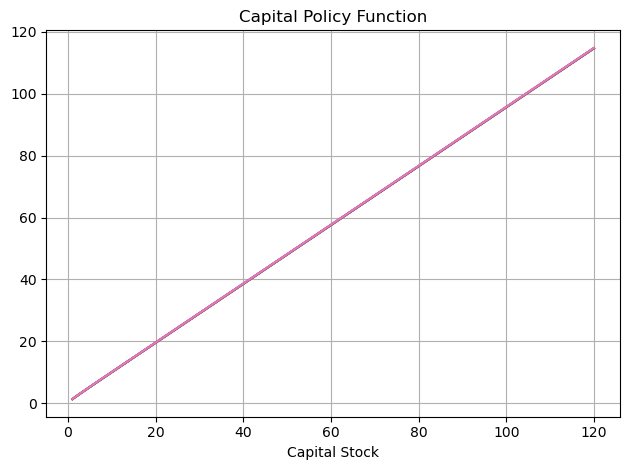

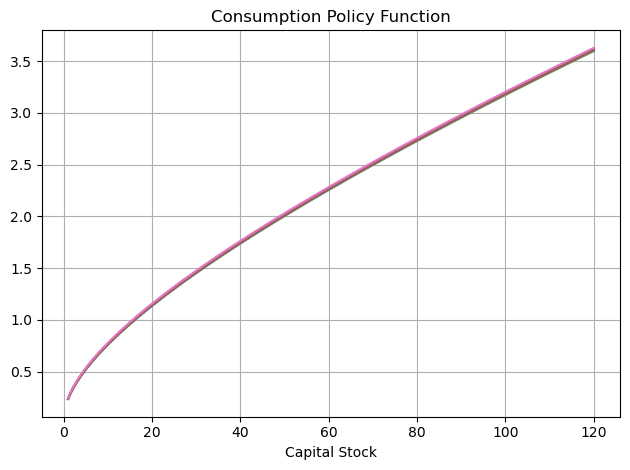

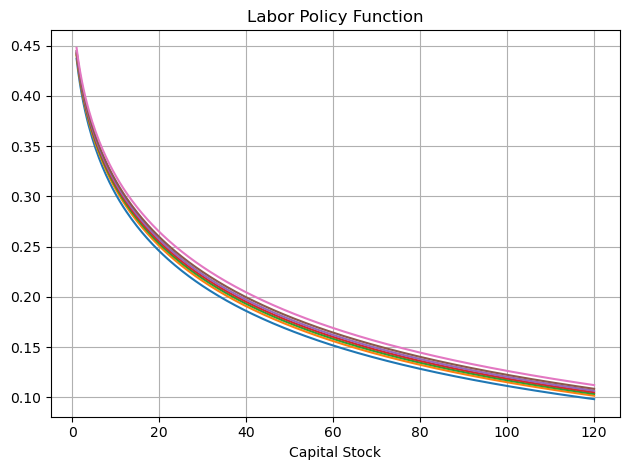

In [14]:
if plots:
    ccm = np.zeros((N,ns))
    hcm = np.zeros((N,ns))
    kprcm = np.zeros((N,ns))
    
    PC = polrbc.copy()
    KC = PC[0:N,0]
    
    for i in np.arange(0,ns):
        for l in np.arange(0,N):
            ccm[l,i]=PC[l+i*N,1]
            kprcm[l,i]=PC[l+i*N,2]
            hcm[l,i]=PC[l+i*N,3]

            
    # Plot capital, consumption, and labor policy functions
    fig1, ax1 = plt.subplots()
    
    ax1.plot(KC, kprcm)
    ax1.set(xlabel='Capital Stock', title='Capital Policy Function')
    ax1.grid()
    
    plt.tight_layout()
    plt.savefig('Hansen_PI_capital_policy.jpg', dpi=800)
    plt.show()
    plt.close(fig1)

    fig2, ax2 = plt.subplots()
    
    ax2.plot(KC, ccm)
    ax2.set(xlabel='Capital Stock', title='Consumption Policy Function')
    ax2.grid()
    
    plt.tight_layout()
    plt.savefig('Hansen_PI_consumption_policy.jpg', dpi=800)
    plt.show()
    plt.close(fig2)
    

    fig3, ax3 = plt.subplots()
    
    ax3.plot(KC, hcm)
    ax3.set(xlabel='Capital Stock', title='Labor Policy Function')
    ax3.grid()
    
    plt.tight_layout()
    plt.savefig('Hansen_PI_labor_policy.jpg', dpi=800)
    plt.show()
    plt.close(fig3)
    
    

In [15]:
if simu:
    np.random.seed(1337)
    T = 115
    N = 100
    
    std_mat = np.zeros((N,6))
    cc_mat = np.zeros((N,6))
    
    for j in np.arange(0,N):
        S = mcsim(zz,pi,T)
        sz = S[0]
        
        kt = np.zeros((T+1,))
        it = np.zeros((T,))
        ct = np.zeros((T,))
        yt = np.zeros((T,))
        lt = np.zeros((T,))
        prot = np.zeros((T,))
        zt = np.zeros((T,))
        
        kt[0] = k_ss
        
        for i in np.arange(0,T):
            sz = S[i]
            zt[i] = zz[sz]
            
            zzz = np.abs((k-kt[i])).argmin()
            
            mm = zzz
            if (kt[i]<=k[mm] and mm>0):
                weight=(k[mm]-kt[i])/(k[mm]-k[mm-1])
                kt[i+1]=weight*kpr[mm-1,sz]+(1-weight)*kpr[mm,sz]
                lt[i]=weight*h[mm-1,sz]+(1-weight)*h[mm,sz]

            else:
                weight=(k[mm+1]-kt[i])/(k[mm+1]-k[mm])
                kt[i+1]=weight*kpr[mm,sz]+(1-weight)*kpr[mm+1,sz]
                lt[i]=weight*h[mm,sz]+(1-weight)*h[mm+1,sz]

            
                        
            yt[i]=zt[i]*lt[i]**(1-theta)*kt[i]**theta;
            ct[i]=(yt[i]+(1-delta)*kt[i]-kt[i+1])
            it[i]=kt[i+1]-(1-delta)*kt[i]
            prot[i]=yt[i]/lt[i]
        
        
        kk = np.log(kt[0:T])[np.newaxis,:]
        yy = np.log(yt[0:T])[np.newaxis,:]
        cc = np.log(ct[0:T])[np.newaxis,:]
        inn = np.log(it[0:T])[np.newaxis,:]
        hh = np.log(lt[0:T])[np.newaxis,:]
        prodd = np.log(prot[0:T])[np.newaxis,:]
        
        
        dhp, dtr = hp1(np.concatenate((yy.T, inn.T, cc.T, kk.T, hh.T, prodd.T),axis=1), 1600)
        std_mat[j,:] = np.std(dhp,axis=0,ddof=1)*100
        Corr = np.corrcoef(dhp,rowvar=False)
        cc_mat[j,:] = Corr[:,0]
        
        
        
    std = np.mean(std_mat,axis=0)
    corr = np.mean(cc_mat,axis=0)
    
    
    print('HANSEN: std(x)/std(y) corr(x,y) for y, i, c, k, h, prod')
    print(np.concatenate((np.array([[1.36, 4.24, 0.42, 0.36, 0.7, 0.68]]).T/1.36, \
                          np.array([[1, 0.99, 0.89, 0.06, 0.98, 0.98]]).T),axis=1))
    print('std(x) std(x)/std(y) corr(x,y) for y, i, c, k, h, prod:')
    print(np.concatenate((std[:,np.newaxis], (std/std[0])[:,np.newaxis], corr[:,np.newaxis]), axis=1))


HANSEN: std(x)/std(y) corr(x,y) for y, i, c, k, h, prod
[[1.     1.    ]
 [3.1176 0.99  ]
 [0.3088 0.89  ]
 [0.2647 0.06  ]
 [0.5147 0.98  ]
 [0.5    0.98  ]]
std(x) std(x)/std(y) corr(x,y) for y, i, c, k, h, prod:
[[1.6559 1.     1.    ]
 [5.4728 3.3051 0.9905]
 [0.4386 0.2649 0.8375]
 [0.4481 0.2706 0.0487]
 [0.9172 0.5539 0.983 ]
 [0.7731 0.4669 0.9762]]


In [16]:
#!jupyter nbconvert --to script hansen_pi.ipynb